<a href="https://colab.research.google.com/github/dhanushba/Data_Science_Assignment/blob/main/Customer_Segmentation_or_Clustering/Dhanush_B_A_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Step 1: Load the datasets
customers_df = pd.read_csv('Customers.csv')  # Customer dataset
products_df = pd.read_csv('Products.csv')    # Product dataset
transactions_df = pd.read_csv('Transactions.csv')  # Transactions dataset

In [4]:
# Step 2: Merge datasets to get relevant customer and product information
merged_df = transactions_df.merge(products_df, on='ProductID', how='left')
merged_df = merged_df.merge(customers_df, on='CustomerID', how='left')

In [5]:
# Step 3: Feature Engineering
# Aggregate customer transaction data
customer_features = merged_df.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    purchase_count=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_purchase_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
).reset_index()

# Calculate spend per product category for each customer
category_features = merged_df.groupby(['CustomerID', 'Category']).agg(
    category_spend=pd.NamedAgg(column='TotalValue', aggfunc='sum')
).reset_index()

# Pivot category features to create a category spend matrix
category_pivot = category_features.pivot_table(index='CustomerID', columns='Category', values='category_spend', fill_value=0)

# Merge customer features with category spend matrix
full_features = pd.merge(customer_features, category_pivot, on='CustomerID', how='left')


In [6]:
# Step 4: Data Preprocessing
# Select relevant features for clustering
features = full_features[['total_spent', 'purchase_count', 'avg_purchase_value'] + list(category_pivot.columns)]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [7]:
# Step 5: Clustering with K-Means
# Determine the number of clusters (K)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

# Add the cluster label to the customer profile
full_features['Cluster'] = kmeans.labels_


In [8]:
# Step 6: Clustering Evaluation Metrics
# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
# Silhouette Score
sil_score = silhouette_score(scaled_features, kmeans.labels_)

# Print clustering metrics
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")


DB Index: 1.6951165463787106
Silhouette Score: 0.15592672916561726


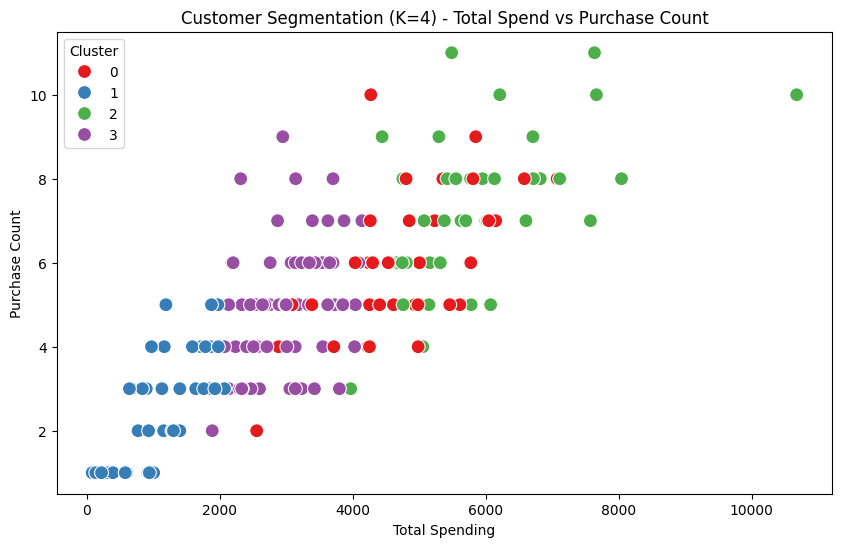

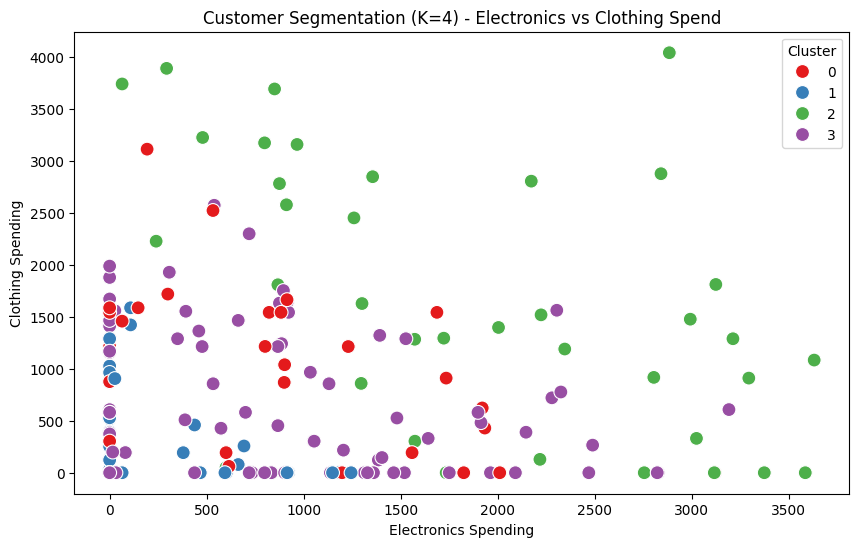

In [9]:
# Step 7: Visualizing the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=full_features['total_spent'], y=full_features['purchase_count'], hue=full_features['Cluster'], palette='Set1', s=100)
plt.title(f'Customer Segmentation (K=4) - Total Spend vs Purchase Count')
plt.xlabel('Total Spending')
plt.ylabel('Purchase Count')
plt.legend(title='Cluster')
plt.show()

# Visualizing clusters based on spending in categories (e.g., Electronics vs Clothing)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=full_features['Electronics'], y=full_features['Clothing'], hue=full_features['Cluster'], palette='Set1', s=100)
plt.title(f'Customer Segmentation (K=4) - Electronics vs Clothing Spend')
plt.xlabel('Electronics Spending')
plt.ylabel('Clothing Spending')
plt.legend(title='Cluster')
plt.show()


In [10]:
# Step 8: Output the clustered customers
full_features.to_csv('Clustered_Customers_with_Products.csv', index=False)

# Display the first few rows of the clustered customer profile
print(full_features.head())

  CustomerID  total_spent  purchase_count  avg_purchase_value    Books  \
0      C0001      3354.52               5             670.904   114.60   
1      C0002      1862.74               4             465.685     0.00   
2      C0003      2725.38               4             681.345     0.00   
3      C0004      5354.88               8             669.360  1888.48   
4      C0005      2034.24               3             678.080     0.00   

   Clothing  Electronics  Home Decor  Cluster  
0      0.00      2827.30      412.62        3  
1   1025.46         0.00      837.28        1  
2    122.36      1385.20     1217.82        3  
3      0.00      1355.74     2110.66        0  
4      0.00      1180.38      853.86        1  
